In [137]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import xarray as xr

In [138]:
NE_prices = pd.read_csv('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\Niger_food_prices.csv')
NE_prices['date'] = pd.to_datetime(NE_prices['date'])
NE_prices.drop(axis=1, labels=['Maize - Retail', 'Rice (imported) - Retail', 'Sorghum - Retail', 'Beans (niebe) - Retail'], inplace=True)
NE_prices.head()

,date,days,Millet - Retail
0,1990-01-01,7305.0,61.00
1,1990-02-01,7336.0,63.40
2,1990-03-01,7364.0,65.20
3,1990-04-01,7395.0,69.60
4,1990-05-01,7425.0,63.25


In [139]:
#train = NE_prices[NE_prices['date'].dt.strftime('%Y') < '2018']
#test = NE_prices[NE_prices['date'].dt.strftime('%Y') >= '2018']

In [140]:
precip_data = Dataset('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\niger_rainfall.nc')

In [141]:
precip_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.4
    title: CRU TS4.06 Precipitation
    institution: Data held at British Atmospheric Data Centre, RAL, UK.
    source: Run ID = 2204291347. Data generated from:pre.2204291209.dtb
    history: Fri 29 Apr 16:08:23 BST 2022 : User f098 : Program makegridsauto.for called by update.for
    references: Information on the data is available at http://badc.nerc.ac.uk/data/cru/
    comment: Access to these data is available to any registered CEDA user.
    contact: support@ceda.ac.uk
    dimensions(sizes): time(384), lon(32), lat(15)
    variables(dimensions): float32 lon(lon), float32 lat(lat), float32 time(time), float32 pre(time, lat, lon), int32 stn(time, lat, lon)
    groups: 

In [142]:
precip_data.variables.keys()

dict_keys(['lon', 'lat', 'time', 'pre', 'stn'])

In [143]:
for d in precip_data.dimensions.items():
    print(d)

('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 384)
('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 32)
('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 15)


In [144]:
precip = precip_data.variables['pre']
print(precip)

<class 'netCDF4._netCDF4.Variable'>
float32 pre(time, lat, lon)
    _FillValue: 9.96921e+36
    long_name: precipitation
    units: mm/month
    correlation_decay_distance: 450.0
    missing_value: 9.96921e+36
unlimited dimensions: time
current shape = (384, 15, 32)
filling on


In [145]:
def plot_netCDF(file, variable, cmap, title):
    """file = netCDF file, variable = 3 letter variable to map, cmap = plt colormap to use, title = title for map"""
    only_variable = file.variables[variable]
    avg = np.mean(only_variable[:,:,:], axis=0)
    plt.figure()
    map = Basemap(projection='cyl', resolution='c', llcrnrlat=0, urcrnrlat=25, llcrnrlon=-10, urcrnrlon=20)
    map.drawcoastlines(color='blue')
    map.drawcountries()
    lons, lats = np.meshgrid(file.variables['lon'][:], file.variables['lat'][:])
    x, y = map(lons, lats)
    plot = map.contourf(x, y, avg, cmap=cmap)
    cb = map.colorbar(plot, "bottom", size='5%', pad='2%', extend = 'both')
    plt.title(title)
    return plt.show()

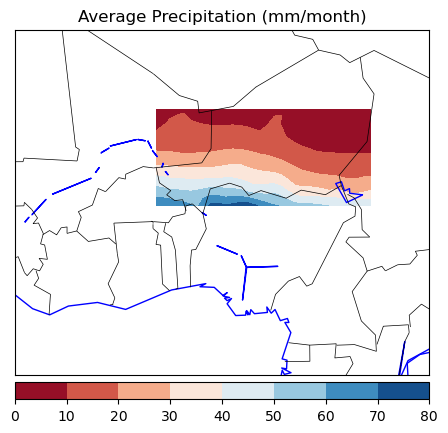

In [146]:
plot_netCDF(file=precip_data, variable='pre', cmap=plt.cm.RdBu, title='Average Precipitation (mm/month)')

In [147]:
rain_ds = xr.open_dataset('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\niger_rainfall.nc')
rain_df_all = rain_ds.to_dataframe()
rain_df_all = rain_df_all.reset_index()
rain_df_all.head()

,lon,lat,time,pre,stn
0,0.25,12.25,1989-01-16,0.0,8.0
1,0.25,12.25,1989-02-15,0.0,8.0
2,0.25,12.25,1989-03-16,7.4,8.0
3,0.25,12.25,1989-04-16,5.3,8.0
4,0.25,12.25,1989-05-16,14.6,8.0


In [148]:
rain_df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184320 entries, 0 to 184319
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   lon     184320 non-null  float64       
 1   lat     184320 non-null  float64       
 2   time    184320 non-null  datetime64[ns]
 3   pre     184320 non-null  float32       
 4   stn     184320 non-null  float64       
dtypes: datetime64[ns](1), float32(1), float64(3)
memory usage: 6.3 MB


In [149]:
rain_df_all.describe()

,lon,lat,pre,stn
count,184320.000000,184320.000000,184320.000000,184320.000000
mean,8.000000,15.750000,23.972895,4.012408
std,4.616559,2.160253,47.858341,3.302175
min,0.250000,12.250000,0.000000,0.000000
25%,4.125000,13.750000,0.000000,1.000000
50%,8.000000,15.750000,0.800000,4.000000
75%,11.875000,17.750000,23.100000,8.000000
max,15.750000,19.250000,390.600006,8.000000


In [150]:
def netCDF_to_df(ds):
    df_all = ds.to_dataframe()
    df_all = df_all.reset_index()
    df = df_all.groupby('time').mean().sort_values(by='time')
    df.reset_index(inplace=True)
    df.drop(axis=1, labels=['lon', 'lat', 'stn'], inplace=True)
    df['date'] = df['time'].dt.to_period('M').dt.to_timestamp()
    df.drop(axis=1, labels='time', inplace=True)
    return df

In [151]:
rain_df = netCDF_to_df(rain_ds)
rain_df.head()

,pre,date
0,0.046250,1989-01-01
1,0.068958,1989-02-01
2,0.400000,1989-03-01
3,0.366875,1989-04-01
4,9.039167,1989-05-01


In [152]:
wet_days_data = Dataset('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\niger_wet_days.nc')
wet_days_data.variables.keys()

dict_keys(['lon', 'lat', 'time', 'wet', 'stn'])

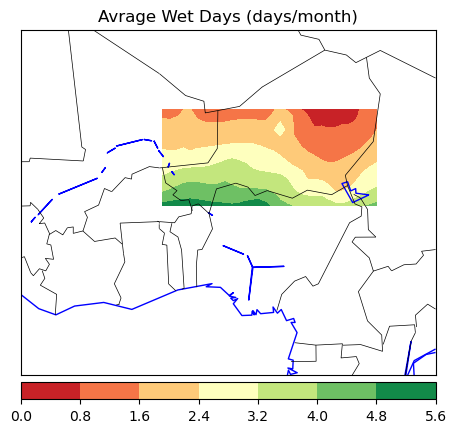

In [153]:
plot_netCDF(wet_days_data, 'wet', plt.cm.RdYlGn, title='Avrage Wet Days (days/month)')

In [154]:
wet_ds = xr.open_dataset('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\niger_wet_days.nc', decode_timedelta=False)
wet_days_df = netCDF_to_df(ds=wet_ds)
wet_days_df.head()

,wet,date
0,0.024375,1989-01-01
1,0.043812,1989-02-01
2,0.123979,1989-03-01
3,0.161250,1989-04-01
4,1.639375,1989-05-01


In [155]:
temp_data = Dataset('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\niger_surface_temp.nc')
temp_data.variables.keys()

dict_keys(['lon', 'lat', 'time', 'tmp', 'stn'])

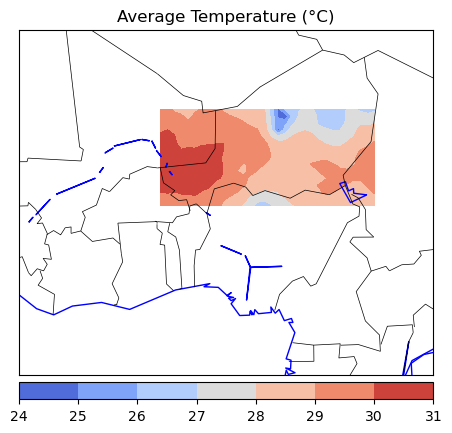

In [156]:
plot_netCDF(temp_data, 'tmp', plt.cm.coolwarm, title='Average Temperature (°C)')

In [157]:
temp_ds = xr.open_dataset('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\niger_surface_temp.nc')
temp_df = netCDF_to_df(ds=temp_ds)
temp_df.head()

,tmp,date
0,18.631042,1989-01-01
1,20.856459,1989-02-01
2,26.759792,1989-03-01
3,31.531250,1989-04-01
4,33.367916,1989-05-01


In [158]:
def get_prev_months(df, num, variable):
    
    """A function to take a dataframe (df), and return the lagged values for the 
    (num) number of previous months in a new dataframe. (variable) is the three letter
    column name used to subset the column correctly"""

    for i in range(num):

        i = i + 1
        
        column_name = variable + '-' + str(i)

        shift_df = df.shift(i)
        shift_df.rename(columns={variable:column_name}, inplace=True)
        df = df.merge(shift_df[column_name], left_index=True, right_index=True) 
        
    return df

In [159]:
temp_df_new = get_prev_months(temp_df, 6, 'tmp')
temp_df_new.head()

,tmp,date,tmp-1,tmp-2,tmp-3,tmp-4,tmp-5,tmp-6
0,18.631042,1989-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,20.856459,1989-02-01,18.631042,NaN,NaN,NaN,NaN,NaN
2,26.759792,1989-03-01,20.856459,18.631042,NaN,NaN,NaN,NaN
3,31.531250,1989-04-01,26.759792,20.856459,18.631042,NaN,NaN,NaN
4,33.367916,1989-05-01,31.531250,26.759792,20.856459,18.631042,NaN,NaN


In [160]:
rain_df_new = get_prev_months(rain_df, 6, 'pre')
rain_df_new.head()

,pre,date,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6
0,0.046250,1989-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,0.068958,1989-02-01,0.046250,NaN,NaN,NaN,NaN,NaN
2,0.400000,1989-03-01,0.068958,0.046250,NaN,NaN,NaN,NaN
3,0.366875,1989-04-01,0.400000,0.068958,0.046250,NaN,NaN,NaN
4,9.039167,1989-05-01,0.366875,0.400000,0.068958,0.04625,NaN,NaN


In [161]:
wet_days_df_new = get_prev_months(wet_days_df, 6, 'wet')
wet_days_df_new.head()

,wet,date,wet-1,wet-2,wet-3,wet-4,wet-5,wet-6
0,0.024375,1989-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,0.043812,1989-02-01,0.024375,NaN,NaN,NaN,NaN,NaN
2,0.123979,1989-03-01,0.043812,0.024375,NaN,NaN,NaN,NaN
3,0.161250,1989-04-01,0.123979,0.043812,0.024375,NaN,NaN,NaN
4,1.639375,1989-05-01,0.161250,0.123979,0.043812,0.024375,NaN,NaN


In [162]:
climate_df = rain_df_new.merge(wet_days_df_new, on='date')
climate_df = climate_df.merge(temp_df_new, on='date')
climate_df.head()

,pre,date,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,wet,wet-1,...,wet-4,wet-5,wet-6,tmp,tmp-1,tmp-2,tmp-3,tmp-4,tmp-5,tmp-6
0,0.046250,1989-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0.024375,NaN,...,NaN,NaN,NaN,18.631042,NaN,NaN,NaN,NaN,NaN,NaN
1,0.068958,1989-02-01,0.046250,NaN,NaN,NaN,NaN,NaN,0.043812,0.024375,...,NaN,NaN,NaN,20.856459,18.631042,NaN,NaN,NaN,NaN,NaN
2,0.400000,1989-03-01,0.068958,0.046250,NaN,NaN,NaN,NaN,0.123979,0.043812,...,NaN,NaN,NaN,26.759792,20.856459,18.631042,NaN,NaN,NaN,NaN
3,0.366875,1989-04-01,0.400000,0.068958,0.046250,NaN,NaN,NaN,0.161250,0.123979,...,NaN,NaN,NaN,31.531250,26.759792,20.856459,18.631042,NaN,NaN,NaN
4,9.039167,1989-05-01,0.366875,0.400000,0.068958,0.04625,NaN,NaN,1.639375,0.161250,...,0.024375,NaN,NaN,33.367916,31.531250,26.759792,20.856459,18.631042,NaN,NaN


In [163]:
df = NE_prices.merge(climate_df, how='left', on='date')
df.head()

,date,days,Millet - Retail,pre,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,...,wet-4,wet-5,wet-6,tmp,tmp-1,tmp-2,tmp-3,tmp-4,tmp-5,tmp-6
0,1990-01-01,7305.0,61.00,0.048958,0.272917,0.068333,10.813334,32.151253,125.538124,57.626667,...,4.178146,10.317396,7.018458,22.116459,21.728750,25.568333,29.284168,30.892918,29.631460,31.408333
1,1990-02-01,7336.0,63.40,0.069167,0.048958,0.272917,0.068333,10.813334,32.151253,125.538124,...,1.024875,4.178146,10.317396,22.112709,22.116459,21.728750,25.568333,29.284168,30.892918,29.631460
2,1990-03-01,7364.0,65.20,0.040208,0.069167,0.048958,0.272917,0.068333,10.813334,32.151253,...,0.028167,1.024875,4.178146,25.751041,22.112709,22.116459,21.728750,25.568333,29.284168,30.892918
3,1990-04-01,7395.0,69.60,1.666042,0.040208,0.069167,0.048958,0.272917,0.068333,10.813334,...,0.192271,0.028167,1.024875,33.199585,25.751041,22.112709,22.116459,21.728750,25.568333,29.284168
4,1990-05-01,7425.0,63.25,17.283751,1.666042,0.040208,0.069167,0.048958,0.272917,0.068333,...,0.028812,0.192271,0.028167,34.156456,33.199585,25.751041,22.112709,22.116459,21.728750,25.568333


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379 entries, 0 to 378
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             379 non-null    datetime64[ns]
 1   days             379 non-null    float64       
 2   Millet - Retail  379 non-null    float64       
 3   pre              372 non-null    float32       
 4   pre-1            372 non-null    float32       
 5   pre-2            372 non-null    float32       
 6   pre-3            372 non-null    float32       
 7   pre-4            372 non-null    float32       
 8   pre-5            372 non-null    float32       
 9   pre-6            372 non-null    float32       
 10  wet              372 non-null    float32       
 11  wet-1            372 non-null    float32       
 12  wet-2            372 non-null    float32       
 13  wet-3            372 non-null    float32       
 14  wet-4            372 non-null    float32  

In [165]:
df.dropna(inplace=True)

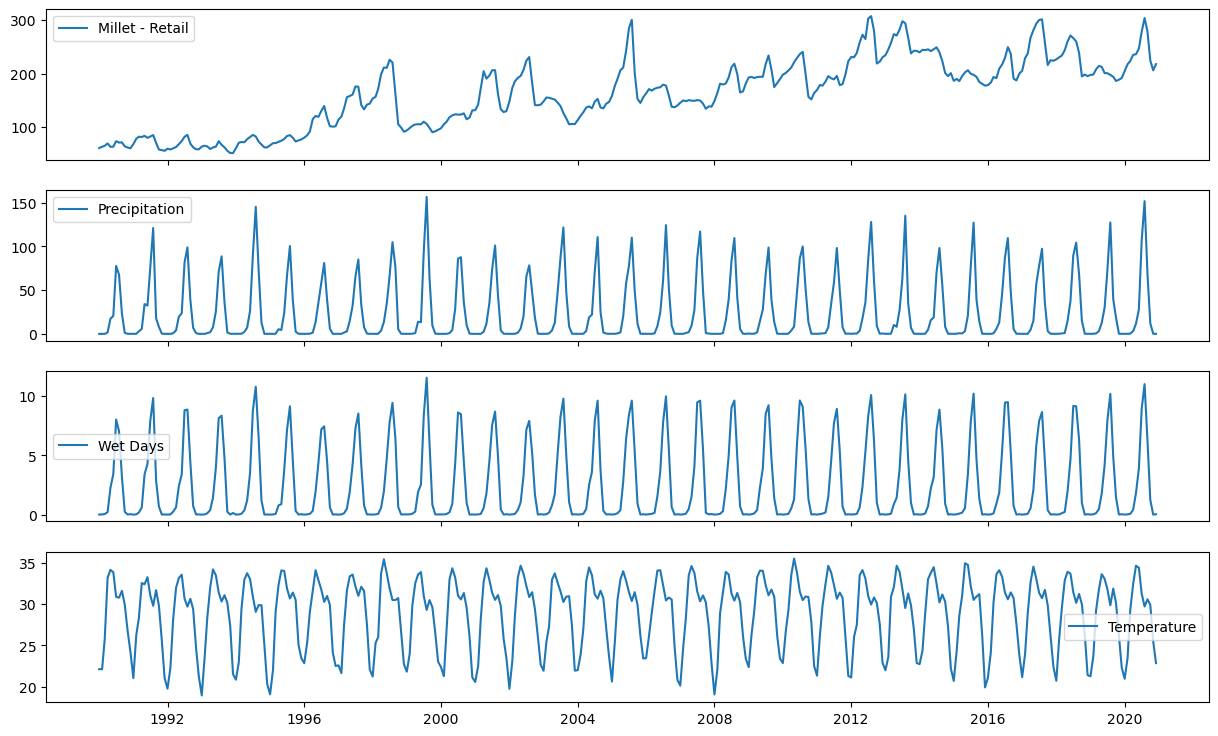

In [166]:
fig, ax = plt.subplots(4, 1, sharex=True)

fig.set_size_inches(15, 9)

ax[0].plot(df.date, df['Millet - Retail'], label='Millet - Retail')
ax[0].legend()
ax[1].plot(df.date, df['pre'], label='Precipitation')
ax[1].legend()
ax[2].plot(df.date, df['wet'], label='Wet Days')
ax[2].legend()
ax[3].plot(df.date, df['tmp'], label='Temperature')
ax[3].legend()

plt.show()

In [167]:
train = df[df['date'].dt.strftime('%Y') < '2018']
test = df[df['date'].dt.strftime('%Y') >= '2018']

In [173]:
y_train = train[['Millet - Retail']]
y_test = test[['Millet - Retail']]

In [172]:
X_train = train.iloc[:,3:]
X_test = test.iloc[:,3:]

In [174]:
sarima = auto_arima(y=y_train, X=X_train, start_P=1, start_Q=1, test='adf', 
                    max_P=3, max_Q=3, seasonal=True, m=12, trace=True, d=1, D=1)

sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=2448.462, Time=6.78 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2661.114, Time=1.34 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2577.835, Time=5.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=5.13 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=2446.360, Time=6.23 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=2601.570, Time=2.76 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=inf, Time=13.03 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=2558.675, Time=5.79 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=2446.336, Time=13.01 sec
 ARIMA(2,1,2)(2,1,2)[12]             : AIC=2417.641, Time=13.28 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=2417.172, Time=14.96 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=2468.810, Time=12.83 sec
 ARIMA(2,1,2)(3,1,1)[12]             : AIC=2414.962, Time=19.50 sec
 ARIMA(2,1,2)(3,1,0)[12]             : AIC=2417.612, Time=19.11 sec
 ARIMA(2,1,2)(3,1,2)[1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  336
Model:             SARIMAX(3, 1, 2)x(3, 1, [1], 12)   Log Likelihood               -1176.441
Date:                              Tue, 07 Mar 2023   AIC                           2414.882
Time:                                      17:06:32   BIC                           2531.989
Sample:                                           0   HQIC                          2461.629
                                              - 336                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pre           -0.1605      0.133     -1.210      0.226      -0.421       0.100
pre-1         -0.3580      0.191     -1.874      0.061      -0.733       0.017
pre-2         -0.3705      0.245     -1.510      0.131      -0.851       0.110
pre-3         -0.4162      0.221     -1.885      0.059      -0.849       0.017
pre-4         -0.0592      0.245     -0.242      0.809      -0.540       0.421
pre-5          0.1438      0.208      0.691      0.490      -0.264       0.552
pre-6          0.0799      0.144      0.557      0.578      -0.201       0.361
wet            1.7478      2.219      0.788      0.431      -2.601       6.097
wet-1          5.4805      3.045      1.800      0.072      -0.488      11.449
wet-2          9.2003      3.545      2.596      0.009       2.253      16.148
wet-3          7.7585      3.252      2.386      0.017       1.385      14.132
wet-4         -1.1762      3.529     -0.333      0.739      -8.092       5.740
wet-5         -4.0141      2.813     -1.427      0.154      -9.528       1.500
wet-6         -2.5753      2.076     -1.241      0.215      -6.643       1.493
tmp           -0.4186      0.655     -0.639      0.523      -1.702       0.865
tmp-1         -0.8552      0.875     -0.977      0.328      -2.570       0.860
tmp-2         -0.2631      1.074     -0.245      0.806      -2.368       1.842
tmp-3          1.7274      1.082      1.597      0.110      -0.393       3.847
tmp-4          0.9049      1.128      0.802      0.422      -1.306       3.116
tmp-5          0.4905      0.896      0.548      0.584      -1.265       2.246
tmp-6          0.1068      0.561      0.191      0.849      -0.992       1.206
ar.L1         -1.0079      0.143     -7.039      0.000      -1.289      -0.727
ar.L2         -0.4235      0.115     -3.682      0.000      -0.649      -0.198
ar.L3          0.0829      0.091      0.914      0.361      -0.095       0.261
ma.L1          1.3691      0.123     11.092      0.000       1.127       1.611
ma.L2          0.8171      0.123      6.660      0.000       0.577       1.058
ar.S.L12      -0.5301      0.138     -3.852      0.000      -0.800      -0.260
ar.S.L24      -0.6300      0.082     -7.717      0.000      -0.790      -0.470
ar.S.L36      -0.2642      0.096     -2.755      0.006      -0.452      -0.076
ma.S.L12      -0.3394      0.142     -2.393      0.017      -0.617      -0.061
sigma2        80.2151      5.784     13.868      0.000      68.878      91.552
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               179.35
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                            -0.62
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.43
=========

In [175]:
sarima.params

<bound method ARIMA.params of ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(3, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)>

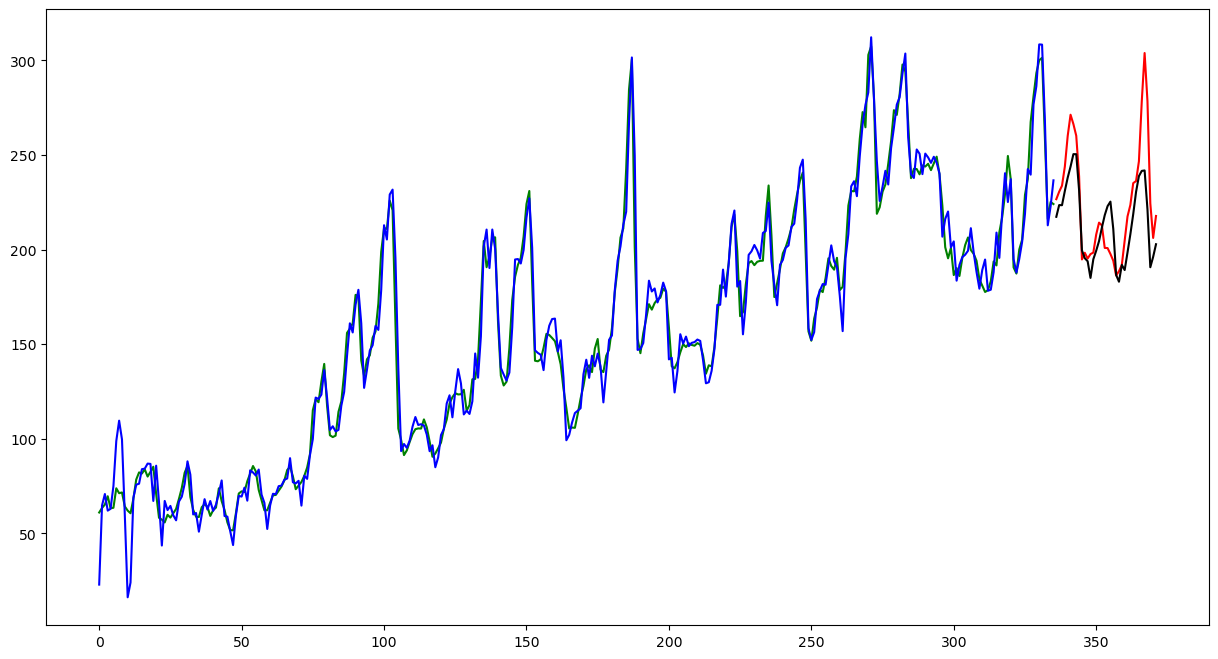

In [176]:
train_predict = sarima.predict_in_sample(X=X_train)
test_predict = sarima.predict(n_periods=len(y_test), X=X_test)

plt.rcParams["figure.figsize"] = (15,8)
plt.plot(y_train, color='g', label='Train data')
plt.plot(train_predict, color='b', label='Train prediction')
plt.plot(y_test, color='r', label='Test data')
plt.plot(test_predict, color='k', label='Test prediction')
plt.show()

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [177]:
print('train rmse:', mean_squared_error(y_train, train_predict, squared=False))
print('test rmse:', mean_squared_error(y_test, test_predict, squared=False))

train rmse: 10.180316244498115
test rmse: 20.701221863096148


51.556089626658
366.9503227173336
52.65647673241039
28.005549864494803
76.87632919731783


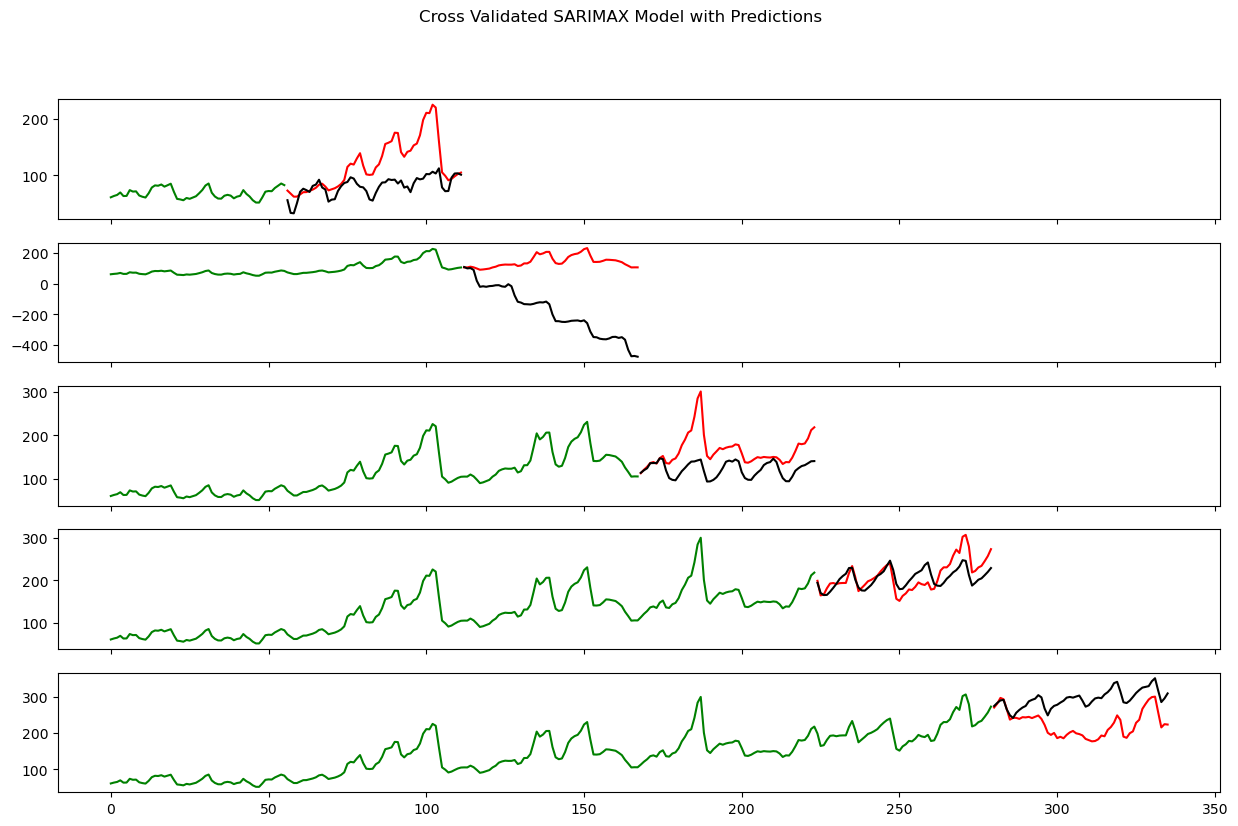

In [178]:
tscv = TimeSeriesSplit()

fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(15, 9)
fig.suptitle('Cross Validated SARIMAX Model with Predictions')

for i, (train_index, test_index) in enumerate(tscv.split(train)):

    # Creating the new Train and Test sets
    cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]

    # Make y and X
    cv_train_y = cv_train[['Millet - Retail']]
    cv_test_y = cv_test[['Millet - Retail']]
    cv_train_X = cv_train.iloc[:,3:]
    cv_test_X = cv_test.iloc[:,3:]

    # Using auto_arima to find the best model for this fold
    sarima = auto_arima(y=cv_train_y, X=cv_train_X, start_P=1, start_Q=1, test='adf', 
                    max_P=3, max_Q=3, seasonal=True, m=12, trace=False, d=1, D=1)

    # Getting predictions for the test fold
    predictions = sarima.predict(n_periods=len(cv_test_y), X=cv_test_X)

    # Print rmse 
    print(mean_squared_error(cv_test_y, predictions, squared=False))

    
    ax[i].plot(cv_train_y, color='g', label='Train data')
    ax[i].plot(cv_test_y, color='r', label='Test data')
    ax[i].plot(predictions, color='k', label='Test prediction')